<a href="https://colab.research.google.com/github/teamProjectIti/tf_Keras/blob/main/Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets
!pip install -U accelerate
!pip install evaluate

import warnings
warnings.filterwarnings('ignore')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.8/375.8 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.10.1
    Uninstalling accelerate-1.10.1:
      Successfully uninstalled accelerate-1.10.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.7 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset


food = load_dataset("rajistics/indian_food_images")



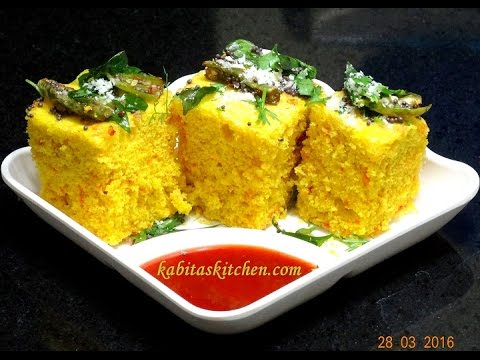

In [3]:
food['train'][0]['image'] # class id => 6

In [4]:
labels = food['train'].features['label'].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(label2id)
print(id2label)

{'burger': 0, 'butter_naan': 1, 'chai': 2, 'chapati': 3, 'chole_bhature': 4, 'dal_makhani': 5, 'dhokla': 6, 'fried_rice': 7, 'idli': 8, 'jalebi': 9, 'kaathi_rolls': 10, 'kadai_paneer': 11, 'kulfi': 12, 'masala_dosa': 13, 'momos': 14, 'paani_puri': 15, 'pakode': 16, 'pav_bhaji': 17, 'pizza': 18, 'samosa': 19}
{0: 'burger', 1: 'butter_naan', 2: 'chai', 3: 'chapati', 4: 'chole_bhature', 5: 'dal_makhani', 6: 'dhokla', 7: 'fried_rice', 8: 'idli', 9: 'jalebi', 10: 'kaathi_rolls', 11: 'kadai_paneer', 12: 'kulfi', 13: 'masala_dosa', 14: 'momos', 15: 'paani_puri', 16: 'pakode', 17: 'pav_bhaji', 18: 'pizza', 19: 'samosa'}


In [5]:
from transformers import AutoImageProcessor

model_ckpt = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(model_ckpt, use_fast=True)

In [6]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

size = (
    image_processor.size['shorted_edge']
    if "shorted_edge" in image_processor.size
    else (image_processor.size['height'], image_processor.size['width'])
)


_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

def transforms(examples):
    examples['pixel_values'] = [_transforms(img.convert('RGB')) for img in examples['image']]
    del examples['image']

    return examples


In [7]:
food = food.with_transform(transforms)

In [8]:
import evaluate
import numpy as np

accuracy = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return accuracy.compute(predictions=predictions, references=labels)


In [9]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForImageClassification.from_pretrained(
    model_ckpt,
    num_labels = len(labels),
    id2label=id2label,
    label2id=label2id
).to(device)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

args = TrainingArguments(
    output_dir = "train_dir",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,
    num_train_epochs=4,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=food['train'],
    eval_dataset=food['test'],
    tokenizer=image_processor,
    compute_metrics=compute_metrics
)

trainer.train()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

In [ ]:
trainer.save_model('food_classification')

In [ ]:
from transformers import pipeline

pipe = pipeline("image-classification", model='food_classification', device=device)

In [ ]:
import requests
from PIL import Image
from io import BytesIO

url ='https://www.indianhealthyrecipes.com/wp-content/uploads/2015/10/pizza-recipe-1.jpg'
# url = 'https://www.indianhealthyrecipes.com/wp-content/uploads/2015/10/pizza-recipe-1.jpg'
response = requests.get(url)
image = Image.open(BytesIO(response.content))
image.show()